steps of CD pipeline for staging:

build an `ubuntu agent` and define the following steps on this agent:

Based on the image, here are the stages (steps) of the Continuous Deployment (CD) pipeline:

1. **Use Python 3.6**  
   Set the Python version to 3.6.

2. **Add ML Extension**  
   Add the Azure Machine Learning CLI extension.

3. **Deploy to ACI**  
   Deploy the model or application to Azure Container Instances (ACI) using Azure CLI.

4. **Install Requirements**  
   Run a Bash script to install necessary dependencies.

5. **Staging Test**  
   Run tests in the staging environment using Azure CLI.

6. **Publish Staging Test Results**  
   Publish the results of the staging tests for review.



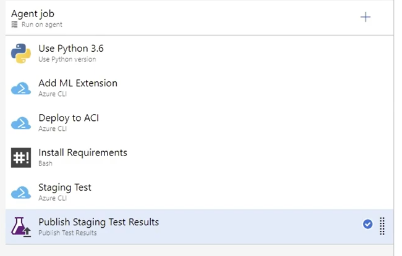

### pipeline as code for CD for staging:

```yaml
trigger: none  # CD pipelines often trigger manually or from artifacts
stages:
  - stage: DeployToStaging
    displayName: 'Deploy to Staging Environment'
    jobs:
      - job: DeployJob
        displayName: 'Deployment Job'
        pool:
          vmImage: 'ubuntu-latest'

        steps:
          - task: UsePythonVersion@0
            inputs:
              versionSpec: '3.6'
            displayName: 'Use Python 3.6'

          - task: AzureCLI@2
            inputs:
              azureSubscription: '<your-service-connection-name>'
              scriptType: 'bash'
              scriptLocation: 'inlineScript'
              inlineScript: |
                az extension add -n azure-cli-ml
            displayName: 'Add ML Extension'

          - task: AzureCLI@2
            inputs:
              azureSubscription: '<your-service-connection-name>'
              scriptType: 'bash'
              scriptLocation: 'inlineScript'
              inlineScript: |
                az ml model deploy -n your-model-name -g your-resource-group --ic inference-config.json --dc deployment-config.json --model-id your-model:1
            displayName: 'Deploy to ACI'

          - task: Bash@3
            inputs:
              targetType: 'inline'
              script: |
                pip install -r requirements.txt
            displayName: 'Install Requirements'

          - task: AzureCLI@2
            inputs:
              azureSubscription: '<your-service-connection-name>'
              scriptType: 'bash'
              scriptLocation: 'inlineScript'
              inlineScript: |
                python staging_test.py
            displayName: 'Staging Test'

          - task: PublishTestResults@2
            inputs:
              testResultsFiles: '**/test-results.xml'
              testRunTitle: 'Publish Staging Test Results'
            condition: succeededOrFailed()
            displayName: 'Publish Staging Test Results'
```

### Q. explains Deploy to ACI?
You use `az ml model deploy` to:
- create a machine for deploying your model
- build a docker image 
  - Azure ML automatically builds the container image behind the scenes for ACI based on `inference config `(Python script, environment) and deployment config (compute resources).
  - ✅ No need to build/push the Docker image yourself — Azure handles it.
- run a container from the image
- spin up a REST API endpoint in ACI that serves your model.

```yaml
- task: AzureCLI@2
    inputs:
    azureSubscription: '<your-service-connection-name>'
    scriptType: 'bash'
    scriptLocation: 'inlineScript'
    inlineScript: |
        az ml model deploy -n your-model-name -g your-resource-group --ic inference-config.json --dc deployment-config.json --model-id your-model:1
    displayName: 'Deploy to ACI'
```

### Q. when you send data to the rest api, what compute resources it uses?

When you deploy your model to ACI (Azure Container Instances), it runs inside a Docker container that Azure spins up just for your deployment. The container runs on Azure-managed VMs, and you specify the compute resources it needs.

⚙️ Resource Settings You Control:
You define compute resources for the container in your deployment configuration, typically in a file like deployment-config.json. Example:

```json
{
  "computeType": "ACI",
  "containerResourceRequirements": {
    "cpu": 1,
    "memoryInGB": 2
  }
}
```
